# **EM Routing on Pavia University**
### **Parameters:**

WindowSize: 19

No. of PCA Components: 20

No. of epochs: 50

Batch size: 64

Learning Rate: 3e-3

EM Iterations: 2

Architecture: [64, 32, 16, 16, 9]

Percentage of training data used: 50% (21388 samples)

Percentage of validation data: 10% (4277 samples)

Percentage of testing data: 40% (17111 samples)

## **Imports & Initialization**

In [1]:
from datetime import datetime
import math
from operator import truediv
import os
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np

import scipy.io as sio

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, cohen_kappa_score

import spectral

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 2

# Making the model deterministic

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)

torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## **Parameters**

### Dataset Parameters

In [3]:
test_ratio = 0.8
val_and_test_ratio = 0.5
windowSize = 19
batch_size = 32
no_of_PCA_components = 20

### Model Parameters

In [4]:
# model architecture
A, B, C, D = 64, 32, 16, 16

# EM Iterations
em_iters = 2

# PCA Componenets
pca_components = 20

# Epochs
epochs = 50

# Learning rate
lr = 3e-3

# Weight Decay
wd = 2e-7

# Test Intervals
test_intervals = 1

# Log Interval
log_interval = 10

# No. of classes
num_class = 9

## **Loading Data**

#### Defining Required Functions

In [5]:
def loadData():
    images = sio.loadmat('Data/Pavia/PaviaU.mat')['paviaU']
    labels = sio.loadmat('Data/Pavia/PaviaU_gt.mat')['paviaU_gt']
    return images, labels

In [6]:
def applyPCA(X, n_components=no_of_PCA_components, seed=seed):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=n_components, whiten=True, random_state=seed)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], n_components))
    return newX

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=windowSize, removeZeroLabels=True):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    
    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1

    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    
    return patchesData, patchesLabels

In [9]:
def dataSplit(X, y, val_and_test_ratio=val_and_test_ratio, test_ratio=test_ratio, random_state=seed):
    X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=val_and_test_ratio, random_state=random_state, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=test_ratio, random_state=random_state, stratify=y_val_and_test)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
def convertToDataloader(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=batch_size, K=no_of_PCA_components):

    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

#### Loading Data

In [11]:
X, y = loadData()
X.shape, y.shape

((610, 340, 103), (610, 340))

In [12]:
X = applyPCA(X)
X.shape

(610, 340, 20)

In [13]:
X, y = createImageCubes(X, y)
X.shape, y.shape

((42776, 19, 19, 20), (42776,))

In [14]:
X = X.transpose(0, 3, 1, 2)
X.shape, y.shape

((42776, 20, 19, 19), (42776,))

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = dataSplit(X, y)
print("X Train: ", X_train.shape)
print("Y Train: ", y_train.shape)
print("X Val: ", X_val.shape)
print("Y Val: ", y_val.shape)
print("X Test: ", X_test.shape)
print("Y Test: ", y_test.shape)

X Train:  (21388, 20, 19, 19)
Y Train:  (21388,)
X Val:  (4277, 20, 19, 19)
Y Val:  (4277,)
X Test:  (17111, 20, 19, 19)
Y Test:  (17111,)


In [16]:
train_loader, val_loader, test_loader = convertToDataloader(X_train, y_train, X_val, y_val, X_test, y_test)

In [17]:
dataloaders = {'train': train_loader, 'valid': val_loader,'test': test_loader}

## **Model**

#### Capsule Network Model

In [18]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, A=32, B=32, K=1, P=4, stride=1):
        super(PrimaryCaps, self).__init__()
        self.pose = nn.Conv2d(in_channels=A, out_channels=B*P*P,
                            kernel_size=K, stride=stride, bias=True)
        self.a = nn.Conv2d(in_channels=A, out_channels=B,
                            kernel_size=K, stride=stride, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        p = self.pose(x)
        a = self.a(x)
        a = self.sigmoid(a)
        out = torch.cat([p, a], dim=1)
        out = out.permute(0, 2, 3, 1)
        return out

In [19]:
class ConvCaps(nn.Module):

    def __init__(self, B=32, C=32, K=3, P=4, stride=2, iters=3,
                 coor_add=False, w_shared=False):
        super(ConvCaps, self).__init__()
        self.B = B
        self.C = C
        self.K = K
        self.P = P
        self.psize = P*P
        self.stride = stride
        self.iters = iters
        self.coor_add = coor_add
        self.w_shared = w_shared
        self.eps = 1e-8
        self._lambda = 1e-03
        self.ln_2pi = torch.cuda.FloatTensor(1).fill_(math.log(2*math.pi))

        self.beta_u = nn.Parameter(torch.zeros(C))
        self.beta_a = nn.Parameter(torch.zeros(C))

        self.weights = nn.Parameter(torch.randn(1, K*K*B, C, P, P))
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=2)

    def m_step(self, a_in, r, v, eps, b, B, C, psize):

        r = r * a_in
        r = r / (r.sum(dim=2, keepdim=True) + eps)
        r_sum = r.sum(dim=1, keepdim=True)
        coeff = r / (r_sum + eps)
        coeff = coeff.view(b, B, C, 1)

        mu = torch.sum(coeff * v, dim=1, keepdim=True)
        sigma_sq = torch.sum(coeff * (v - mu)**2, dim=1, keepdim=True) + eps

        r_sum = r_sum.view(b, C, 1)
        sigma_sq = sigma_sq.view(b, C, psize)
        cost_h = (self.beta_u.view(C, 1) + torch.log(sigma_sq.sqrt())) * r_sum

        a_out = self.sigmoid(self._lambda*(self.beta_a - cost_h.sum(dim=2)))
        sigma_sq = sigma_sq.view(b, 1, C, psize)

        return a_out, mu, sigma_sq

    def e_step(self, mu, sigma_sq, a_out, v, eps, b, C):

        ln_p_j_h = -1. * (v - mu)**2 / (2 * sigma_sq) \
                    - torch.log(sigma_sq.sqrt()) \
                    - 0.5*self.ln_2pi

        ln_ap = ln_p_j_h.sum(dim=3) + torch.log(a_out.view(b, 1, C))
        r = self.softmax(ln_ap)
        return r

    def caps_em_routing(self, v, a_in, C, eps):

        b, B, c, psize = v.shape
        assert c == C
        assert (b, B, 1) == a_in.shape

        r = torch.cuda.FloatTensor(b, B, C).fill_(1./C)
        for iter_ in range(self.iters):
            a_out, mu, sigma_sq = self.m_step(a_in, r, v, eps, b, B, C, psize)
            if iter_ < self.iters - 1:
                r = self.e_step(mu, sigma_sq, a_out, v, eps, b, C)

        return mu, a_out

    def add_pathes(self, x, B, K, psize, stride):

        b, h, w, c = x.shape
        assert h == w
        assert c == B*(psize+1)
        oh = ow = int(((h - K )/stride)+ 1)
        idxs = [[(h_idx + k_idx) \
                for k_idx in range(0, K)] \
                for h_idx in range(0, h - K + 1, stride)]
        x = x[:, idxs, :, :]
        x = x[:, :, :, idxs, :]
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        return x, oh, ow

    def transform_view(self, x, w, C, P, w_shared=False):

        b, B, psize = x.shape
        assert psize == P*P

        x = x.view(b, B, 1, P, P)
        if w_shared:
            hw = int(B / w.size(1))
            w = w.repeat(1, hw, 1, 1, 1)

        w = w.repeat(b, 1, 1, 1, 1)
        x = x.repeat(1, 1, C, 1, 1)
        v = torch.matmul(x, w)
        v = v.view(b, B, C, P*P)
        return v

    def add_coord(self, v, b, h, w, B, C, psize):

        assert h == w
        v = v.view(b, h, w, B, C, psize)
        coor = torch.arange(h, dtype=torch.float32) / h
        coor_h = torch.cuda.FloatTensor(1, h, 1, 1, 1, self.psize).fill_(0.)
        coor_w = torch.cuda.FloatTensor(1, 1, w, 1, 1, self.psize).fill_(0.)
        coor_h[0, :, 0, 0, 0, 0] = coor
        coor_w[0, 0, :, 0, 0, 1] = coor
        v = v + coor_h + coor_w
        v = v.view(b, h*w*B, C, psize)
        return v

    def forward(self, x):
        b, h, w, c = x.shape
        if not self.w_shared:
            x, oh, ow = self.add_pathes(x, self.B, self.K, self.psize, self.stride)

            p_in = x[:, :, :, :, :, :self.B*self.psize].contiguous()
            a_in = x[:, :, :, :, :, self.B*self.psize:].contiguous()
            p_in = p_in.view(b*oh*ow, self.K*self.K*self.B, self.psize)
            a_in = a_in.view(b*oh*ow, self.K*self.K*self.B, 1)
            v = self.transform_view(p_in, self.weights, self.C, self.P)

            p_out, a_out = self.caps_em_routing(v, a_in, self.C, self.eps)
            p_out = p_out.view(b, oh, ow, self.C*self.psize)
            a_out = a_out.view(b, oh, ow, self.C)
            out = torch.cat([p_out, a_out], dim=3)
        else:
            assert c == self.B*(self.psize+1)
            assert 1 == self.K
            assert 1 == self.stride
            p_in = x[:, :, :, :self.B*self.psize].contiguous()
            p_in = p_in.view(b, h*w*self.B, self.psize)
            a_in = x[:, :, :, self.B*self.psize:].contiguous()
            a_in = a_in.view(b, h*w*self.B, 1)

            v = self.transform_view(p_in, self.weights, self.C, self.P, self.w_shared)

            if self.coor_add:
                v = self.add_coord(v, b, h, w, self.B, self.C, self.psize)

            _, out = self.caps_em_routing(v, a_in, self.C, self.eps)

        return out

In [20]:
class CapsNet(nn.Module):

    def __init__(self, A=32, B=32, C=32, D=32, E=10, K=3, P=4, iters=3):
        super(CapsNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=pca_components, out_channels=A,
                               kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=A, eps=0.001,
                                 momentum=0.1, affine=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.primary_caps = PrimaryCaps(A, B, 1, P, stride=1)
        self.conv_caps1 = ConvCaps(B, C, K, P, stride=2, iters=iters)
        self.conv_caps2 = ConvCaps(C, D, K, P, stride=1, iters=iters)
        self.class_caps = ConvCaps(D, E, 1, P, stride=1, iters=iters,
                                        coor_add=True, w_shared=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.primary_caps(x)
        x = self.conv_caps1(x)
        x = self.conv_caps2(x)
        x = self.class_caps(x)
        return x

#### Loss Function

In [21]:
class SpreadLoss(_Loss):

    def __init__(self, m_min=0.2, m_max=0.9, num_class=9):
        super(SpreadLoss, self).__init__()
        self.m_min = m_min
        self.m_max = m_max
        self.num_class = num_class

    def forward(self, x, target, r):
        b, E = x.shape
        assert E == self.num_class
        margin = self.m_min + (self.m_max - self.m_min)*r

        at = torch.cuda.FloatTensor(b).fill_(0)
        for i, a in enumerate(target):
            lb = int(a.item())
            at[i] = x[i][lb]
        at = at.view(b, 1).repeat(1, E)

        zeros = x.new_zeros(x.shape)
        loss = torch.max(margin - (at - x), zeros)
        loss = loss**2
        loss = loss.sum() / b - margin**2

        return loss

## **Training Setup**

#### Data Preparation

In [22]:
train_loader = dataloaders['train']
valid_loader = dataloaders['valid']
test_loader = dataloaders['test']

#### Accuracy Function

In [23]:
def accuracy(output, target):
    y_pred = output.argmax(dim=1).float()
    res = accuracy_score(target.to('cpu'), y_pred.to('cpu')) * 100
    return res

#### Learning Rate Decay function

In [24]:
def exp_lr_decay(optimizer, global_step, init_lr = 3e-3, decay_steps = 20000,
                                        decay_rate = 0.96, lr_clip = 3e-3 ,staircase=False):
        
    if staircase:
        lr = (init_lr * decay_rate**(global_step // decay_steps)) 
    else:
        lr = (init_lr * decay_rate**(global_step / decay_steps)) 
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### Average Meter Class

In [25]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Train Function

In [26]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()

    model.train()
    train_len = len(train_loader)
    epoch_acc = 0
    end = time.time()

    for batch_idx, (data, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        r = (1.*batch_idx + (epoch-1)*train_len) / (epochs*train_len)
        loss = criterion(output, target, r)
        acc = accuracy(output, target)
        
        global_step = (batch_idx+1) + (epoch - 1) * len(train_loader) 
        exp_lr_decay(optimizer=optimizer, global_step=global_step)
        
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        epoch_acc += acc
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}\t[{}/{} ({:.0f}%)]\t'
                  'Loss: {:.6f}\tAccuracy: {:.6f}\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item(), acc,
                  batch_time=batch_time, data_time=data_time))
            
    return epoch_acc

#### Test Function

In [27]:
def test(test_loader, model, criterion, device, test=False):
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, r=1).item()
            acc += accuracy(output, target)

    test_loss /= test_len
    acc /= test_len
    if test:
        print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))
    else:
        print('\nVal set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
            test_loss, acc))

    return test_loss, acc

## **Training Process**

#### Model Initialization

In [28]:
model = CapsNet(A=A, B=B, C=C, D=D, E=num_class,
                    iters=em_iters).to(device)

#### Model Summary

In [29]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    print("\n Total Trainable Parameters: ", total_param)

model_summary(model)

conv1.weight : 64x20x5x5 = 32000
conv1.bias : 64
bn1.weight : 64
bn1.bias : 64
primary_caps.pose.weight : 512x64x1x1 = 32768
primary_caps.pose.bias : 512
primary_caps.a.weight : 32x64x1x1 = 2048
primary_caps.a.bias : 32
conv_caps1.beta_u : 16
conv_caps1.beta_a : 16
conv_caps1.weights : 1x288x16x4x4 = 73728
conv_caps2.beta_u : 16
conv_caps2.beta_a : 16
conv_caps2.weights : 1x144x16x4x4 = 36864
class_caps.beta_u : 9
class_caps.beta_a : 9
class_caps.weights : 1x16x9x4x4 = 2304

 Total Trainable Parameters:  180530


#### Training Time!

In [30]:
criterion = SpreadLoss(num_class=num_class, m_min=0.2, m_max=0.5)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

In [31]:
# Trainging Loop

training_start_time = time.time()

best_acc = test(valid_loader, model, criterion, device)[1]

for epoch in range(1, epochs + 1):
    acc = train(train_loader, model, criterion, optimizer, epoch, device)
    acc /= len(train_loader)

    current_acc = test(valid_loader, model, criterion, device)[1]
    
    if current_acc > best_acc:
        best_acc = current_acc
        print("-------------------- HIGHEST ACCURACY ---------------------------")
        torch.save(model.state_dict(), './model.pth')

training_stop_time = time.time()

best_acc = max(best_acc, test(valid_loader, model, criterion, device)[0])
print('\n\nBest validation accuracy: {:.6f}'.format(best_acc))

print('\n Total time taken in seconds: ', training_stop_time - training_start_time)


Val set: Average loss: 2.062524, Accuracy: 9.959133 

Train Epoch: 1	[0/21388 (0%)]	Loss: 0.422256	Accuracy: 0.000000	Time 0.451 (0.451)	Data 0.003 (0.003)
Train Epoch: 1	[320/21388 (1%)]	Loss: 0.151808	Accuracy: 56.250000	Time 0.152 (0.169)	Data 0.001 (0.001)
Train Epoch: 1	[640/21388 (3%)]	Loss: 0.136097	Accuracy: 50.000000	Time 0.153 (0.160)	Data 0.001 (0.006)
Train Epoch: 1	[960/21388 (4%)]	Loss: 0.074839	Accuracy: 78.125000	Time 0.152 (0.156)	Data 0.001 (0.007)
Train Epoch: 1	[1280/21388 (6%)]	Loss: 0.028299	Accuracy: 90.625000	Time 0.152 (0.155)	Data 0.002 (0.008)
Train Epoch: 1	[1600/21388 (7%)]	Loss: 0.044512	Accuracy: 87.500000	Time 0.154 (0.154)	Data 0.001 (0.009)
Train Epoch: 1	[1920/21388 (9%)]	Loss: 0.036181	Accuracy: 90.625000	Time 0.153 (0.153)	Data 0.001 (0.009)
Train Epoch: 1	[2240/21388 (10%)]	Loss: 0.015922	Accuracy: 93.750000	Time 0.154 (0.153)	Data 0.001 (0.009)
Train Epoch: 1	[2560/21388 (12%)]	Loss: 0.023749	Accuracy: 87.500000	Time 0.149 (0.152)	Data 0.001 (0.0

Train Epoch: 2	[2560/21388 (12%)]	Loss: 0.002100	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 2	[2880/21388 (13%)]	Loss: 0.000898	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 2	[3200/21388 (15%)]	Loss: 0.000117	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.001 (0.011)
Train Epoch: 2	[3520/21388 (16%)]	Loss: 0.000237	Accuracy: 100.000000	Time 0.153 (0.147)	Data 0.001 (0.011)
Train Epoch: 2	[3840/21388 (18%)]	Loss: 0.000619	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 2	[4160/21388 (19%)]	Loss: 0.000084	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 2	[4480/21388 (21%)]	Loss: 0.003282	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 2	[4800/21388 (22%)]	Loss: 0.001235	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 2	[5120/21388 (24%)]	Loss: 0.000022	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.001 (0.011)
Train Epoch: 2	[5440/21388 (

Train Epoch: 3	[5120/21388 (24%)]	Loss: 0.000016	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[5440/21388 (25%)]	Loss: 0.002138	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[5760/21388 (27%)]	Loss: 0.010324	Accuracy: 96.875000	Time 0.153 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[6080/21388 (28%)]	Loss: 0.009884	Accuracy: 96.875000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[6400/21388 (30%)]	Loss: 0.000600	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[6720/21388 (31%)]	Loss: 0.000791	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[7040/21388 (33%)]	Loss: 0.001311	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[7360/21388 (34%)]	Loss: 0.003256	Accuracy: 96.875000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[7680/21388 (36%)]	Loss: 0.000430	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 3	[8000/21388 (37%

Train Epoch: 4	[7680/21388 (36%)]	Loss: 0.000144	Accuracy: 100.000000	Time 0.145 (0.149)	Data 0.001 (0.011)
Train Epoch: 4	[8000/21388 (37%)]	Loss: 0.000477	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.002 (0.011)
Train Epoch: 4	[8320/21388 (39%)]	Loss: 0.000118	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 4	[8640/21388 (40%)]	Loss: 0.001698	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 4	[8960/21388 (42%)]	Loss: 0.000059	Accuracy: 100.000000	Time 0.150 (0.149)	Data 0.002 (0.011)
Train Epoch: 4	[9280/21388 (43%)]	Loss: 0.000456	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 4	[9600/21388 (45%)]	Loss: 0.000003	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 4	[9920/21388 (46%)]	Loss: 0.002831	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 4	[10240/21388 (48%)]	Loss: 0.002867	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 4	[10560/21388

Train Epoch: 5	[10560/21388 (49%)]	Loss: 0.000795	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 5	[10880/21388 (51%)]	Loss: 0.000018	Accuracy: 100.000000	Time 0.154 (0.148)	Data 0.001 (0.011)
Train Epoch: 5	[11200/21388 (52%)]	Loss: 0.000003	Accuracy: 100.000000	Time 0.153 (0.148)	Data 0.001 (0.011)
Train Epoch: 5	[11520/21388 (54%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 5	[11840/21388 (55%)]	Loss: 0.000015	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 5	[12160/21388 (57%)]	Loss: 0.000052	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.002 (0.011)
Train Epoch: 5	[12480/21388 (58%)]	Loss: 0.001545	Accuracy: 100.000000	Time 0.153 (0.148)	Data 0.001 (0.011)
Train Epoch: 5	[12800/21388 (60%)]	Loss: 0.001482	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 5	[13120/21388 (61%)]	Loss: 0.000185	Accuracy: 100.000000	Time 0.154 (0.149)	Data 0.001 (0.011)
Train Epoch: 5	[134

Train Epoch: 6	[13440/21388 (63%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.147 (0.151)	Data 0.001 (0.011)
Train Epoch: 6	[13760/21388 (64%)]	Loss: 0.000314	Accuracy: 100.000000	Time 0.147 (0.151)	Data 0.001 (0.011)
Train Epoch: 6	[14080/21388 (66%)]	Loss: 0.000443	Accuracy: 100.000000	Time 0.149 (0.151)	Data 0.001 (0.011)
Train Epoch: 6	[14400/21388 (67%)]	Loss: 0.000169	Accuracy: 100.000000	Time 0.149 (0.150)	Data 0.002 (0.011)
Train Epoch: 6	[14720/21388 (69%)]	Loss: 0.000026	Accuracy: 100.000000	Time 0.148 (0.150)	Data 0.001 (0.011)
Train Epoch: 6	[15040/21388 (70%)]	Loss: 0.000088	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 6	[15360/21388 (72%)]	Loss: 0.000099	Accuracy: 100.000000	Time 0.148 (0.150)	Data 0.001 (0.011)
Train Epoch: 6	[15680/21388 (73%)]	Loss: 0.000401	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.002 (0.011)
Train Epoch: 6	[16000/21388 (75%)]	Loss: 0.000462	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 6	[163

Train Epoch: 7	[16320/21388 (76%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch: 7	[16640/21388 (78%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.154 (0.150)	Data 0.001 (0.011)
Train Epoch: 7	[16960/21388 (79%)]	Loss: 0.000137	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 7	[17280/21388 (81%)]	Loss: 0.000050	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 7	[17600/21388 (82%)]	Loss: 0.000392	Accuracy: 100.000000	Time 0.153 (0.150)	Data 0.001 (0.011)
Train Epoch: 7	[17920/21388 (84%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.153 (0.150)	Data 0.001 (0.011)
Train Epoch: 7	[18240/21388 (85%)]	Loss: 0.000161	Accuracy: 100.000000	Time 0.153 (0.150)	Data 0.001 (0.011)
Train Epoch: 7	[18560/21388 (87%)]	Loss: 0.001021	Accuracy: 100.000000	Time 0.154 (0.150)	Data 0.001 (0.011)
Train Epoch: 7	[18880/21388 (88%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 7	[192

Train Epoch: 8	[18880/21388 (88%)]	Loss: 0.000256	Accuracy: 100.000000	Time 0.150 (0.149)	Data 0.001 (0.011)
Train Epoch: 8	[19200/21388 (90%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 8	[19520/21388 (91%)]	Loss: 0.000045	Accuracy: 100.000000	Time 0.145 (0.149)	Data 0.001 (0.011)
Train Epoch: 8	[19840/21388 (93%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.149 (0.149)	Data 0.002 (0.011)
Train Epoch: 8	[20160/21388 (94%)]	Loss: 0.000044	Accuracy: 100.000000	Time 0.150 (0.149)	Data 0.002 (0.011)
Train Epoch: 8	[20480/21388 (96%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 8	[20800/21388 (97%)]	Loss: 0.000109	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 8	[21120/21388 (99%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.145 (0.149)	Data 0.001 (0.011)

Val set: Average loss: 0.106742, Accuracy: 99.673507 

Train Epoch: 9	[0/21388 (0%)]	Loss: 0.000000	Accuracy: 100.000000	Time 

Train Epoch: 10	[320/21388 (1%)]	Loss: 0.000990	Accuracy: 100.000000	Time 0.146 (0.139)	Data 0.001 (0.010)
Train Epoch: 10	[640/21388 (3%)]	Loss: 0.000530	Accuracy: 100.000000	Time 0.145 (0.143)	Data 0.001 (0.010)
Train Epoch: 10	[960/21388 (4%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.144)	Data 0.001 (0.010)
Train Epoch: 10	[1280/21388 (6%)]	Loss: 0.000398	Accuracy: 100.000000	Time 0.146 (0.145)	Data 0.001 (0.011)
Train Epoch: 10	[1600/21388 (7%)]	Loss: 0.000583	Accuracy: 100.000000	Time 0.146 (0.146)	Data 0.001 (0.011)
Train Epoch: 10	[1920/21388 (9%)]	Loss: 0.000010	Accuracy: 100.000000	Time 0.147 (0.146)	Data 0.001 (0.011)
Train Epoch: 10	[2240/21388 (10%)]	Loss: 0.001614	Accuracy: 100.000000	Time 0.146 (0.146)	Data 0.001 (0.011)
Train Epoch: 10	[2560/21388 (12%)]	Loss: 0.000730	Accuracy: 100.000000	Time 0.146 (0.146)	Data 0.001 (0.011)
Train Epoch: 10	[2880/21388 (13%)]	Loss: 0.000098	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.001 (0.011)
Train Epoch: 10	[3200/21388 

Train Epoch: 11	[2880/21388 (13%)]	Loss: 0.000597	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.002 (0.011)
Train Epoch: 11	[3200/21388 (15%)]	Loss: 0.000175	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 11	[3520/21388 (16%)]	Loss: 0.000357	Accuracy: 100.000000	Time 0.153 (0.148)	Data 0.001 (0.011)
Train Epoch: 11	[3840/21388 (18%)]	Loss: 0.000012	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 11	[4160/21388 (19%)]	Loss: 0.001704	Accuracy: 100.000000	Time 0.148 (0.148)	Data 0.001 (0.011)
Train Epoch: 11	[4480/21388 (21%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 11	[4800/21388 (22%)]	Loss: 0.000067	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 11	[5120/21388 (24%)]	Loss: 0.002024	Accuracy: 100.000000	Time 0.150 (0.148)	Data 0.001 (0.011)
Train Epoch: 11	[5440/21388 (25%)]	Loss: 0.000717	Accuracy: 100.000000	Time 0.154 (0.148)	Data 0.001 (0.011)
Train Epoch: 11	[5

Train Epoch: 12	[5120/21388 (24%)]	Loss: 0.000009	Accuracy: 100.000000	Time 0.153 (0.150)	Data 0.001 (0.011)
Train Epoch: 12	[5440/21388 (25%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.150 (0.150)	Data 0.001 (0.011)
Train Epoch: 12	[5760/21388 (27%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 12	[6080/21388 (28%)]	Loss: 0.000095	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 12	[6400/21388 (30%)]	Loss: 0.000545	Accuracy: 100.000000	Time 0.149 (0.150)	Data 0.002 (0.011)
Train Epoch: 12	[6720/21388 (31%)]	Loss: 0.000011	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 12	[7040/21388 (33%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 12	[7360/21388 (34%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.153 (0.150)	Data 0.001 (0.011)
Train Epoch: 12	[7680/21388 (36%)]	Loss: 0.000220	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 12	[8

Train Epoch: 13	[7680/21388 (36%)]	Loss: 0.004033	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[8000/21388 (37%)]	Loss: 0.010694	Accuracy: 96.875000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[8320/21388 (39%)]	Loss: 0.000006	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[8640/21388 (40%)]	Loss: 0.000011	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[8960/21388 (42%)]	Loss: 0.000781	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[9280/21388 (43%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[9600/21388 (45%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[9920/21388 (46%)]	Loss: 0.000103	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[10240/21388 (48%)]	Loss: 0.000161	Accuracy: 100.000000	Time 0.150 (0.150)	Data 0.001 (0.011)
Train Epoch: 13	[10

Train Epoch: 14	[10240/21388 (48%)]	Loss: 0.000400	Accuracy: 100.000000	Time 0.146 (0.151)	Data 0.001 (0.011)
Train Epoch: 14	[10560/21388 (49%)]	Loss: 0.000759	Accuracy: 100.000000	Time 0.151 (0.151)	Data 0.001 (0.011)
Train Epoch: 14	[10880/21388 (51%)]	Loss: 0.000388	Accuracy: 100.000000	Time 0.152 (0.151)	Data 0.001 (0.011)
Train Epoch: 14	[11200/21388 (52%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.144 (0.151)	Data 0.002 (0.011)
Train Epoch: 14	[11520/21388 (54%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 14	[11840/21388 (55%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 14	[12160/21388 (57%)]	Loss: 0.000012	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 14	[12480/21388 (58%)]	Loss: 0.000414	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 14	[12800/21388 (60%)]	Loss: 0.022801	Accuracy: 93.750000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoc

Train Epoch: 15	[12800/21388 (60%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 15	[13120/21388 (61%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 15	[13440/21388 (63%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 15	[13760/21388 (64%)]	Loss: 0.000595	Accuracy: 100.000000	Time 0.145 (0.148)	Data 0.001 (0.011)
Train Epoch: 15	[14080/21388 (66%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 15	[14400/21388 (67%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.001 (0.011)
Train Epoch: 15	[14720/21388 (69%)]	Loss: 0.002948	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 15	[15040/21388 (70%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 15	[15360/21388 (72%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Ep

Train Epoch: 16	[15360/21388 (72%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 16	[15680/21388 (73%)]	Loss: 0.000591	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 16	[16000/21388 (75%)]	Loss: 0.000009	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 16	[16320/21388 (76%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.153 (0.150)	Data 0.002 (0.011)
Train Epoch: 16	[16640/21388 (78%)]	Loss: 0.000062	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 16	[16960/21388 (79%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 16	[17280/21388 (81%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 16	[17600/21388 (82%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.150 (0.150)	Data 0.001 (0.011)
Train Epoch: 16	[17920/21388 (84%)]	Loss: 0.000033	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epo

Train Epoch: 17	[17920/21388 (84%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.002 (0.011)
Train Epoch: 17	[18240/21388 (85%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.145 (0.148)	Data 0.001 (0.011)
Train Epoch: 17	[18560/21388 (87%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.001 (0.011)
Train Epoch: 17	[18880/21388 (88%)]	Loss: 0.000286	Accuracy: 100.000000	Time 0.145 (0.148)	Data 0.001 (0.011)
Train Epoch: 17	[19200/21388 (90%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.150 (0.148)	Data 0.001 (0.011)
Train Epoch: 17	[19520/21388 (91%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.144 (0.148)	Data 0.001 (0.011)
Train Epoch: 17	[19840/21388 (93%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.145 (0.148)	Data 0.001 (0.011)
Train Epoch: 17	[20160/21388 (94%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.144 (0.148)	Data 0.002 (0.011)
Train Epoch: 17	[20480/21388 (96%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train 

Train Epoch: 18	[20480/21388 (96%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 18	[20800/21388 (97%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 18	[21120/21388 (99%)]	Loss: 0.004696	Accuracy: 96.875000	Time 0.146 (0.148)	Data 0.001 (0.011)

Val set: Average loss: 0.053459, Accuracy: 99.743470 

Train Epoch: 19	[0/21388 (0%)]	Loss: 0.048041	Accuracy: 93.750000	Time 0.058 (0.058)	Data 0.002 (0.002)
Train Epoch: 19	[320/21388 (1%)]	Loss: 0.010966	Accuracy: 96.875000	Time 0.146 (0.141)	Data 0.001 (0.010)
Train Epoch: 19	[640/21388 (3%)]	Loss: 0.001585	Accuracy: 100.000000	Time 0.151 (0.144)	Data 0.001 (0.010)
Train Epoch: 19	[960/21388 (4%)]	Loss: 0.003193	Accuracy: 100.000000	Time 0.146 (0.145)	Data 0.001 (0.011)
Train Epoch: 19	[1280/21388 (6%)]	Loss: 0.000034	Accuracy: 100.000000	Time 0.146 (0.146)	Data 0.001 (0.011)
Train Epoch: 19	[1600/21388 (7%)]	Loss: 0.000607	Accuracy: 100.000000	Time 0.153 (0

Train Epoch: 20	[1600/21388 (7%)]	Loss: 0.002451	Accuracy: 100.000000	Time 0.145 (0.146)	Data 0.001 (0.011)
Train Epoch: 20	[1920/21388 (9%)]	Loss: 0.000138	Accuracy: 100.000000	Time 0.146 (0.146)	Data 0.001 (0.011)
Train Epoch: 20	[2240/21388 (10%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.001 (0.011)
Train Epoch: 20	[2560/21388 (12%)]	Loss: 0.001064	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.002 (0.011)
Train Epoch: 20	[2880/21388 (13%)]	Loss: 0.000267	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 20	[3200/21388 (15%)]	Loss: 0.000005	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.002 (0.011)
Train Epoch: 20	[3520/21388 (16%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.145 (0.147)	Data 0.001 (0.011)
Train Epoch: 20	[3840/21388 (18%)]	Loss: 0.000102	Accuracy: 100.000000	Time 0.152 (0.147)	Data 0.001 (0.011)
Train Epoch: 20	[4160/21388 (19%)]	Loss: 0.000009	Accuracy: 100.000000	Time 0.145 (0.147)	Data 0.001 (0.011)
Train Epoch: 20	[448

Train Epoch: 21	[3840/21388 (18%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.145 (0.147)	Data 0.001 (0.011)
Train Epoch: 21	[4160/21388 (19%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.152 (0.147)	Data 0.001 (0.011)
Train Epoch: 21	[4480/21388 (21%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.145 (0.147)	Data 0.001 (0.011)
Train Epoch: 21	[4800/21388 (22%)]	Loss: 0.000515	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.001 (0.011)
Train Epoch: 21	[5120/21388 (24%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.144 (0.147)	Data 0.002 (0.011)
Train Epoch: 21	[5440/21388 (25%)]	Loss: 0.000152	Accuracy: 100.000000	Time 0.150 (0.147)	Data 0.001 (0.011)
Train Epoch: 21	[5760/21388 (27%)]	Loss: 0.001034	Accuracy: 100.000000	Time 0.145 (0.147)	Data 0.001 (0.011)
Train Epoch: 21	[6080/21388 (28%)]	Loss: 0.004273	Accuracy: 100.000000	Time 0.154 (0.147)	Data 0.001 (0.011)
Train Epoch: 21	[6400/21388 (30%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.145 (0.147)	Data 0.001 (0.011)
Train Epoch: 21	[6

Train Epoch: 22	[6400/21388 (30%)]	Loss: 0.000011	Accuracy: 100.000000	Time 0.154 (0.149)	Data 0.001 (0.011)
Train Epoch: 22	[6720/21388 (31%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 22	[7040/21388 (33%)]	Loss: 0.000032	Accuracy: 100.000000	Time 0.149 (0.149)	Data 0.001 (0.011)
Train Epoch: 22	[7360/21388 (34%)]	Loss: 0.000387	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 22	[7680/21388 (36%)]	Loss: 0.000550	Accuracy: 100.000000	Time 0.144 (0.149)	Data 0.002 (0.011)
Train Epoch: 22	[8000/21388 (37%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 22	[8320/21388 (39%)]	Loss: 0.000012	Accuracy: 100.000000	Time 0.154 (0.149)	Data 0.001 (0.011)
Train Epoch: 22	[8640/21388 (40%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch: 22	[8960/21388 (42%)]	Loss: 0.000190	Accuracy: 100.000000	Time 0.148 (0.149)	Data 0.001 (0.011)
Train Epoch: 22	[92

Train Epoch: 23	[8960/21388 (42%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.002 (0.011)
Train Epoch: 23	[9280/21388 (43%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 23	[9600/21388 (45%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.001 (0.011)
Train Epoch: 23	[9920/21388 (46%)]	Loss: 0.001515	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.002 (0.011)
Train Epoch: 23	[10240/21388 (48%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.148 (0.150)	Data 0.001 (0.011)
Train Epoch: 23	[10560/21388 (49%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.149 (0.150)	Data 0.001 (0.011)
Train Epoch: 23	[10880/21388 (51%)]	Loss: 0.000486	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.002 (0.011)
Train Epoch: 23	[11200/21388 (52%)]	Loss: 0.000268	Accuracy: 100.000000	Time 0.148 (0.150)	Data 0.001 (0.011)
Train Epoch: 23	[11520/21388 (54%)]	Loss: 0.001002	Accuracy: 100.000000	Time 0.147 (0.150)	Data 0.002 (0.011)
Train Epoch: 2

Train Epoch: 24	[11520/21388 (54%)]	Loss: 0.000094	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.001 (0.011)
Train Epoch: 24	[11840/21388 (55%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 24	[12160/21388 (57%)]	Loss: 0.000005	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.001 (0.011)
Train Epoch: 24	[12480/21388 (58%)]	Loss: 0.000005	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.001 (0.011)
Train Epoch: 24	[12800/21388 (60%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.001 (0.011)
Train Epoch: 24	[13120/21388 (61%)]	Loss: 0.000035	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.001 (0.011)
Train Epoch: 24	[13440/21388 (63%)]	Loss: 0.000024	Accuracy: 100.000000	Time 0.145 (0.149)	Data 0.001 (0.011)
Train Epoch: 24	[13760/21388 (64%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.150 (0.149)	Data 0.001 (0.011)
Train Epoch: 24	[14080/21388 (66%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.145 (0.149)	Data 0.001 (0.011)
Train Ep

Train Epoch: 25	[14080/21388 (66%)]	Loss: 0.000019	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 25	[14400/21388 (67%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.001 (0.011)
Train Epoch: 25	[14720/21388 (69%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 25	[15040/21388 (70%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 25	[15360/21388 (72%)]	Loss: 0.000017	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 25	[15680/21388 (73%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 25	[16000/21388 (75%)]	Loss: 0.022746	Accuracy: 96.875000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 25	[16320/21388 (76%)]	Loss: 0.001317	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 25	[16640/21388 (78%)]	Loss: 0.000046	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch

Train Epoch: 26	[16640/21388 (78%)]	Loss: 0.000013	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 26	[16960/21388 (79%)]	Loss: 0.001820	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 26	[17280/21388 (81%)]	Loss: 0.000045	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 26	[17600/21388 (82%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.148 (0.149)	Data 0.001 (0.011)
Train Epoch: 26	[17920/21388 (84%)]	Loss: 0.000404	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 26	[18240/21388 (85%)]	Loss: 0.000111	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 26	[18560/21388 (87%)]	Loss: 0.000123	Accuracy: 100.000000	Time 0.145 (0.149)	Data 0.002 (0.011)
Train Epoch: 26	[18880/21388 (88%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.148 (0.149)	Data 0.001 (0.011)
Train Epoch: 26	[19200/21388 (90%)]	Loss: 0.000221	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoc

Train Epoch: 27	[19200/21388 (90%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 27	[19520/21388 (91%)]	Loss: 0.000141	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 27	[19840/21388 (93%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 27	[20160/21388 (94%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 27	[20480/21388 (96%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 27	[20800/21388 (97%)]	Loss: 0.000200	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.001 (0.011)
Train Epoch: 27	[21120/21388 (99%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)

Val set: Average loss: 0.023177, Accuracy: 99.953358 

Train Epoch: 28	[0/21388 (0%)]	Loss: 0.000052	Accuracy: 100.000000	Time 0.058 (0.058)	Data 0.002 (0.002)
Train Epoch: 28	[320/21388 (1%)]	Loss: 0.001342	Accuracy: 100.000000	

Train Epoch: 29	[320/21388 (1%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.140)	Data 0.001 (0.010)
Train Epoch: 29	[640/21388 (3%)]	Loss: 0.000045	Accuracy: 100.000000	Time 0.152 (0.145)	Data 0.001 (0.010)
Train Epoch: 29	[960/21388 (4%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.146)	Data 0.001 (0.011)
Train Epoch: 29	[1280/21388 (6%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 29	[1600/21388 (7%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.152 (0.147)	Data 0.001 (0.011)
Train Epoch: 29	[1920/21388 (9%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.144 (0.148)	Data 0.002 (0.011)
Train Epoch: 29	[2240/21388 (10%)]	Loss: 0.000019	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 29	[2560/21388 (12%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 29	[2880/21388 (13%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 29	[3200/2138

Train Epoch: 30	[2880/21388 (13%)]	Loss: 0.000217	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 30	[3200/21388 (15%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 30	[3520/21388 (16%)]	Loss: 0.000019	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 30	[3840/21388 (18%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 30	[4160/21388 (19%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 30	[4480/21388 (21%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 30	[4800/21388 (22%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 30	[5120/21388 (24%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 30	[5440/21388 (25%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 30	[

Train Epoch: 31	[5440/21388 (25%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.144 (0.149)	Data 0.002 (0.011)
Train Epoch: 31	[5760/21388 (27%)]	Loss: 0.030845	Accuracy: 96.875000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 31	[6080/21388 (28%)]	Loss: 0.000331	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 31	[6400/21388 (30%)]	Loss: 0.000037	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 31	[6720/21388 (31%)]	Loss: 0.000517	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 31	[7040/21388 (33%)]	Loss: 0.000055	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 31	[7360/21388 (34%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 31	[7680/21388 (36%)]	Loss: 0.000132	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 31	[8000/21388 (37%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 31	[832

Train Epoch: 32	[8000/21388 (37%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.153 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	[8320/21388 (39%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	[8640/21388 (40%)]	Loss: 0.000003	Accuracy: 100.000000	Time 0.153 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	[8960/21388 (42%)]	Loss: 0.000701	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	[9280/21388 (43%)]	Loss: 0.000008	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	[9600/21388 (45%)]	Loss: 0.000003	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	[9920/21388 (46%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	[10240/21388 (48%)]	Loss: 0.000121	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	[10560/21388 (49%)]	Loss: 0.000529	Accuracy: 100.000000	Time 0.151 (0.148)	Data 0.001 (0.011)
Train Epoch: 32	

Train Epoch: 33	[10560/21388 (49%)]	Loss: 0.000173	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 33	[10880/21388 (51%)]	Loss: 0.000016	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 33	[11200/21388 (52%)]	Loss: 0.000011	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.002 (0.011)
Train Epoch: 33	[11520/21388 (54%)]	Loss: 0.042013	Accuracy: 96.875000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 33	[11840/21388 (55%)]	Loss: 0.000237	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 33	[12160/21388 (57%)]	Loss: 0.000619	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 33	[12480/21388 (58%)]	Loss: 0.000188	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 33	[12800/21388 (60%)]	Loss: 0.001126	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch: 33	[13120/21388 (61%)]	Loss: 0.000255	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch

Train Epoch: 34	[13120/21388 (61%)]	Loss: 0.000009	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 34	[13440/21388 (63%)]	Loss: 0.000012	Accuracy: 100.000000	Time 0.152 (0.147)	Data 0.001 (0.011)
Train Epoch: 34	[13760/21388 (64%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.002 (0.011)
Train Epoch: 34	[14080/21388 (66%)]	Loss: 0.000039	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 34	[14400/21388 (67%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 34	[14720/21388 (69%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 34	[15040/21388 (70%)]	Loss: -0.000000	Accuracy: 100.000000	Time 0.148 (0.147)	Data 0.002 (0.011)
Train Epoch: 34	[15360/21388 (72%)]	Loss: 0.000004	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 34	[15680/21388 (73%)]	Loss: 0.000572	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epo

Train Epoch: 35	[15680/21388 (73%)]	Loss: 0.000005	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 35	[16000/21388 (75%)]	Loss: 0.000708	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 35	[16320/21388 (76%)]	Loss: 0.000066	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 35	[16640/21388 (78%)]	Loss: 0.000540	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 35	[16960/21388 (79%)]	Loss: 0.000025	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 35	[17280/21388 (81%)]	Loss: 0.000936	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 35	[17600/21388 (82%)]	Loss: 0.000132	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 35	[17920/21388 (84%)]	Loss: 0.000195	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 35	[18240/21388 (85%)]	Loss: 0.000266	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoc

Train Epoch: 36	[18240/21388 (85%)]	Loss: 0.000113	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.001 (0.011)
Train Epoch: 36	[18560/21388 (87%)]	Loss: 0.000005	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 36	[18880/21388 (88%)]	Loss: 0.000016	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.001 (0.011)
Train Epoch: 36	[19200/21388 (90%)]	Loss: 0.000019	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 36	[19520/21388 (91%)]	Loss: 0.000099	Accuracy: 100.000000	Time 0.152 (0.147)	Data 0.001 (0.011)
Train Epoch: 36	[19840/21388 (93%)]	Loss: 0.000028	Accuracy: 100.000000	Time 0.152 (0.147)	Data 0.001 (0.011)
Train Epoch: 36	[20160/21388 (94%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 36	[20480/21388 (96%)]	Loss: 0.000002	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 36	[20800/21388 (97%)]	Loss: 0.000014	Accuracy: 100.000000	Time 0.151 (0.147)	Data 0.002 (0.011)
Train Epoc

Train Epoch: 37	[20800/21388 (97%)]	Loss: 0.000147	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 37	[21120/21388 (99%)]	Loss: 0.000233	Accuracy: 100.000000	Time 0.145 (0.148)	Data 0.001 (0.011)

Val set: Average loss: 0.019214, Accuracy: 99.836754 

Train Epoch: 38	[0/21388 (0%)]	Loss: 0.000241	Accuracy: 100.000000	Time 0.055 (0.055)	Data 0.002 (0.002)
Train Epoch: 38	[320/21388 (1%)]	Loss: 0.000568	Accuracy: 100.000000	Time 0.150 (0.138)	Data 0.001 (0.010)
Train Epoch: 38	[640/21388 (3%)]	Loss: 0.000107	Accuracy: 100.000000	Time 0.145 (0.142)	Data 0.001 (0.010)
Train Epoch: 38	[960/21388 (4%)]	Loss: 0.002348	Accuracy: 100.000000	Time 0.145 (0.143)	Data 0.001 (0.010)
Train Epoch: 38	[1280/21388 (6%)]	Loss: 0.017064	Accuracy: 96.875000	Time 0.145 (0.144)	Data 0.001 (0.010)
Train Epoch: 38	[1600/21388 (7%)]	Loss: 0.000185	Accuracy: 100.000000	Time 0.145 (0.144)	Data 0.001 (0.010)
Train Epoch: 38	[1920/21388 (9%)]	Loss: 0.000474	Accuracy: 100.000000	Time 0.145 (0

Train Epoch: 39	[1920/21388 (9%)]	Loss: 0.000064	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 39	[2240/21388 (10%)]	Loss: 0.000055	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 39	[2560/21388 (12%)]	Loss: 0.000034	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch: 39	[2880/21388 (13%)]	Loss: 0.001548	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 39	[3200/21388 (15%)]	Loss: 0.000028	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 39	[3520/21388 (16%)]	Loss: 0.000038	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 39	[3840/21388 (18%)]	Loss: 0.000062	Accuracy: 100.000000	Time 0.152 (0.150)	Data 0.001 (0.011)
Train Epoch: 39	[4160/21388 (19%)]	Loss: 0.000134	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 39	[4480/21388 (21%)]	Loss: 0.000031	Accuracy: 100.000000	Time 0.153 (0.150)	Data 0.001 (0.011)
Train Epoch: 39	[480

Train Epoch: 40	[4480/21388 (21%)]	Loss: 0.000056	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 40	[4800/21388 (22%)]	Loss: 0.000054	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.002 (0.011)
Train Epoch: 40	[5120/21388 (24%)]	Loss: 0.000057	Accuracy: 100.000000	Time 0.153 (0.150)	Data 0.001 (0.011)
Train Epoch: 40	[5440/21388 (25%)]	Loss: 0.000641	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 40	[5760/21388 (27%)]	Loss: 0.000204	Accuracy: 100.000000	Time 0.151 (0.150)	Data 0.001 (0.011)
Train Epoch: 40	[6080/21388 (28%)]	Loss: 0.000117	Accuracy: 100.000000	Time 0.146 (0.150)	Data 0.001 (0.011)
Train Epoch: 40	[6400/21388 (30%)]	Loss: 0.002011	Accuracy: 100.000000	Time 0.145 (0.150)	Data 0.002 (0.011)
Train Epoch: 40	[6720/21388 (31%)]	Loss: 0.000200	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch: 40	[7040/21388 (33%)]	Loss: 0.001850	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 40	[73

Train Epoch: 41	[7040/21388 (33%)]	Loss: 0.000118	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 41	[7360/21388 (34%)]	Loss: 0.000022	Accuracy: 100.000000	Time 0.150 (0.149)	Data 0.002 (0.011)
Train Epoch: 41	[7680/21388 (36%)]	Loss: 0.000021	Accuracy: 100.000000	Time 0.150 (0.149)	Data 0.002 (0.011)
Train Epoch: 41	[8000/21388 (37%)]	Loss: 0.000041	Accuracy: 100.000000	Time 0.158 (0.149)	Data 0.001 (0.011)
Train Epoch: 41	[8320/21388 (39%)]	Loss: 0.000172	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 41	[8640/21388 (40%)]	Loss: 0.000040	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 41	[8960/21388 (42%)]	Loss: 0.000062	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 41	[9280/21388 (43%)]	Loss: 0.000082	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 41	[9600/21388 (45%)]	Loss: 0.000005	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 41	[99

Train Epoch: 42	[9600/21388 (45%)]	Loss: 0.000025	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 42	[9920/21388 (46%)]	Loss: 0.000070	Accuracy: 100.000000	Time 0.153 (0.148)	Data 0.001 (0.011)
Train Epoch: 42	[10240/21388 (48%)]	Loss: 0.000046	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 42	[10560/21388 (49%)]	Loss: 0.000056	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 42	[10880/21388 (51%)]	Loss: 0.000180	Accuracy: 100.000000	Time 0.147 (0.148)	Data 0.001 (0.011)
Train Epoch: 42	[11200/21388 (52%)]	Loss: 0.000028	Accuracy: 100.000000	Time 0.150 (0.148)	Data 0.001 (0.011)
Train Epoch: 42	[11520/21388 (54%)]	Loss: 0.000117	Accuracy: 100.000000	Time 0.143 (0.148)	Data 0.001 (0.011)
Train Epoch: 42	[11840/21388 (55%)]	Loss: 0.000058	Accuracy: 100.000000	Time 0.144 (0.148)	Data 0.001 (0.011)
Train Epoch: 42	[12160/21388 (57%)]	Loss: 0.000008	Accuracy: 100.000000	Time 0.149 (0.148)	Data 0.001 (0.011)
Train Epoch:

Train Epoch: 43	[12160/21388 (57%)]	Loss: 0.000167	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 43	[12480/21388 (58%)]	Loss: 0.000202	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 43	[12800/21388 (60%)]	Loss: 0.000125	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 43	[13120/21388 (61%)]	Loss: 0.000405	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 43	[13440/21388 (63%)]	Loss: 0.000398	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 43	[13760/21388 (64%)]	Loss: 0.000883	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch: 43	[14080/21388 (66%)]	Loss: 0.001511	Accuracy: 100.000000	Time 0.149 (0.149)	Data 0.001 (0.011)
Train Epoch: 43	[14400/21388 (67%)]	Loss: 0.000189	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch: 43	[14720/21388 (69%)]	Loss: 0.000587	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoc

Train Epoch: 44	[14720/21388 (69%)]	Loss: 0.001785	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 44	[15040/21388 (70%)]	Loss: 0.001380	Accuracy: 100.000000	Time 0.145 (0.148)	Data 0.001 (0.011)
Train Epoch: 44	[15360/21388 (72%)]	Loss: 0.000317	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 44	[15680/21388 (73%)]	Loss: 0.000483	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 44	[16000/21388 (75%)]	Loss: 0.000508	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 44	[16320/21388 (76%)]	Loss: 0.000412	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 44	[16640/21388 (78%)]	Loss: 0.000410	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 44	[16960/21388 (79%)]	Loss: 0.005901	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 44	[17280/21388 (81%)]	Loss: 0.000408	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoc

Train Epoch: 45	[17280/21388 (81%)]	Loss: 0.000813	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 45	[17600/21388 (82%)]	Loss: 0.000557	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 45	[17920/21388 (84%)]	Loss: 0.001247	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 45	[18240/21388 (85%)]	Loss: 0.000392	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 45	[18560/21388 (87%)]	Loss: 0.000624	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 45	[18880/21388 (88%)]	Loss: 0.000612	Accuracy: 100.000000	Time 0.152 (0.148)	Data 0.001 (0.011)
Train Epoch: 45	[19200/21388 (90%)]	Loss: 0.042306	Accuracy: 96.875000	Time 0.152 (0.148)	Data 0.002 (0.011)
Train Epoch: 45	[19520/21388 (91%)]	Loss: 0.000408	Accuracy: 100.000000	Time 0.153 (0.149)	Data 0.001 (0.011)
Train Epoch: 45	[19840/21388 (93%)]	Loss: 0.000405	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch

Train Epoch: 46	[19840/21388 (93%)]	Loss: 0.000386	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 46	[20160/21388 (94%)]	Loss: 0.000771	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 46	[20480/21388 (96%)]	Loss: 0.000397	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 46	[20800/21388 (97%)]	Loss: 0.000401	Accuracy: 100.000000	Time 0.146 (0.147)	Data 0.001 (0.011)
Train Epoch: 46	[21120/21388 (99%)]	Loss: 0.000395	Accuracy: 100.000000	Time 0.153 (0.147)	Data 0.001 (0.011)

Val set: Average loss: 0.003488, Accuracy: 99.930037 

Train Epoch: 47	[0/21388 (0%)]	Loss: 0.000217	Accuracy: 100.000000	Time 0.058 (0.058)	Data 0.002 (0.002)
Train Epoch: 47	[320/21388 (1%)]	Loss: 0.000599	Accuracy: 100.000000	Time 0.146 (0.138)	Data 0.001 (0.010)
Train Epoch: 47	[640/21388 (3%)]	Loss: 0.000493	Accuracy: 100.000000	Time 0.146 (0.142)	Data 0.001 (0.010)
Train Epoch: 47	[960/21388 (4%)]	Loss: 0.000404	Accuracy: 100.000000	Time 0

Train Epoch: 48	[640/21388 (3%)]	Loss: 0.000735	Accuracy: 100.000000	Time 0.146 (0.142)	Data 0.001 (0.010)
Train Epoch: 48	[960/21388 (4%)]	Loss: 0.000272	Accuracy: 100.000000	Time 0.145 (0.144)	Data 0.001 (0.010)
Train Epoch: 48	[1280/21388 (6%)]	Loss: 0.000397	Accuracy: 100.000000	Time 0.146 (0.144)	Data 0.001 (0.010)
Train Epoch: 48	[1600/21388 (7%)]	Loss: 0.000580	Accuracy: 100.000000	Time 0.146 (0.145)	Data 0.001 (0.011)
Train Epoch: 48	[1920/21388 (9%)]	Loss: 0.000836	Accuracy: 100.000000	Time 0.146 (0.145)	Data 0.001 (0.011)
Train Epoch: 48	[2240/21388 (10%)]	Loss: 0.000178	Accuracy: 100.000000	Time 0.147 (0.145)	Data 0.001 (0.011)
Train Epoch: 48	[2560/21388 (12%)]	Loss: 0.000558	Accuracy: 100.000000	Time 0.151 (0.145)	Data 0.001 (0.011)
Train Epoch: 48	[2880/21388 (13%)]	Loss: 0.000349	Accuracy: 100.000000	Time 0.146 (0.146)	Data 0.001 (0.011)
Train Epoch: 48	[3200/21388 (15%)]	Loss: 0.000359	Accuracy: 100.000000	Time 0.146 (0.146)	Data 0.001 (0.011)
Train Epoch: 48	[3520/2138

Train Epoch: 49	[3200/21388 (15%)]	Loss: 0.000735	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[3520/21388 (16%)]	Loss: 0.000740	Accuracy: 100.000000	Time 0.150 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[3840/21388 (18%)]	Loss: 0.000671	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[4160/21388 (19%)]	Loss: 0.001012	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[4480/21388 (21%)]	Loss: 0.000880	Accuracy: 100.000000	Time 0.154 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[4800/21388 (22%)]	Loss: 0.000848	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[5120/21388 (24%)]	Loss: 0.001153	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[5440/21388 (25%)]	Loss: 0.000628	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[5760/21388 (27%)]	Loss: 0.001333	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 49	[60

Train Epoch: 50	[5760/21388 (27%)]	Loss: 0.000828	Accuracy: 100.000000	Time 0.146 (0.148)	Data 0.001 (0.011)
Train Epoch: 50	[6080/21388 (28%)]	Loss: 0.001161	Accuracy: 100.000000	Time 0.151 (0.149)	Data 0.002 (0.011)
Train Epoch: 50	[6400/21388 (30%)]	Loss: 0.000797	Accuracy: 100.000000	Time 0.154 (0.149)	Data 0.001 (0.011)
Train Epoch: 50	[6720/21388 (31%)]	Loss: 0.003750	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.002 (0.011)
Train Epoch: 50	[7040/21388 (33%)]	Loss: 0.002084	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 50	[7360/21388 (34%)]	Loss: 0.000928	Accuracy: 100.000000	Time 0.145 (0.149)	Data 0.001 (0.011)
Train Epoch: 50	[7680/21388 (36%)]	Loss: 0.000797	Accuracy: 100.000000	Time 0.147 (0.149)	Data 0.001 (0.011)
Train Epoch: 50	[8000/21388 (37%)]	Loss: 0.001388	Accuracy: 100.000000	Time 0.152 (0.149)	Data 0.001 (0.011)
Train Epoch: 50	[8320/21388 (39%)]	Loss: 0.001848	Accuracy: 100.000000	Time 0.146 (0.149)	Data 0.001 (0.011)
Train Epoch: 50	[86

#### Testing time!

In [32]:
model = CapsNet(A=A, B=B, C=C, D=D, E=num_class, iters=em_iters).to(device)
model.load_state_dict(torch.load('./model.pth'))
test(test_loader, model, criterion, device, test=True);


Test set: Average loss: 0.020262, Accuracy: 99.988318 



## **Inference and Visualization**

#### Inference

In [33]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [34]:
def report(model=model, test_loader=test_loader, criterion=criterion, device=device):

    # Getting prediction vectors from test loader
    y_pred = []
    y_test = []
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(device))
            y_pred.extend(output.argmax(dim=1).float().tolist())
            y_test.extend(target.tolist())

    target_labels = ['0', '1', '2', '3', '4', '5', '6', '7', 
            '8']

    classificationReport = classification_report(y_test, y_pred, target_names=target_labels)
    confusionMatrix = confusion_matrix(y_test, y_pred)
    oa = accuracy_score(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusionMatrix)
    kappa = cohen_kappa_score(y_test, y_pred)
    test_loss, acc = test(test_loader, model, criterion, device, test=True)

    print("------------------------ CONFUSION MATRIX -------------------------")
    print(confusionMatrix)

    print("\n\n---------------------- CLASSIFICATION REPORT ----------------------")
    print(classificationReport)

    print('\n\n------------------------ OVERALL ACCURACY -------------------------')
    print(oa)

    print('\n\n------------------------ AVERAGE ACCURACY -------------------------')
    print(aa)

    print('\n\n--------------------------- KAPPA SCORE ---------------------------')
    print(kappa)

    print('\n\n-------------------------- TEST ACCURACY --------------------------')
    print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))

report()


Test set: Average loss: 0.020262, Accuracy: 99.988318 

------------------------ CONFUSION MATRIX -------------------------
[[2653    0    0    0    0    0    0    0    0]
 [   0 7460    0    0    0    0    0    0    0]
 [   0    0  839    0    0    0    0    0    0]
 [   0    0    0 1226    0    0    0    0    0]
 [   0    0    0    0  538    0    0    0    0]
 [   0    0    0    0    0 2011    0    0    0]
 [   0    0    0    0    0    0  532    0    0]
 [   1    0    0    0    0    0    0 1472    0]
 [   0    0    0    0    0    0    1    0  378]]


---------------------- CLASSIFICATION REPORT ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2653
           1       1.00      1.00      1.00      7460
           2       1.00      1.00      1.00       839
           3       1.00      1.00      1.00      1226
           4       1.00      1.00      1.00       538
           5       1.00      1.00      1.00    

#### Visualization

In [35]:
X,y = loadData()
X = applyPCA(X)
X = padWithZeros(X, windowSize//2)

In [36]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index + windowSize)
    width_slice = slice(width_index, width_index + windowSize)
    patch = data[height_slice, width_slice, :]
    return patch

In [37]:
height,width = y.shape[0],y.shape[1]
outputs = np.zeros((height,width))
model.eval()
with torch.no_grad():
  for i in range(height):
      for j in range(width):
          target = int(y[i,j])
          if target == 0 :
              continue
          else :
              image_patch=Patch(X,i,j)
              X_test_image = image_patch.transpose(2,0,1)
              X_test_image = X_test_image.reshape(1,X_test_image.shape[0],X_test_image.shape[1], X_test_image.shape[2])
              X_test_image = torch.Tensor(X_test_image).to(device)
              pred = model(X_test_image)
              pred = pred.cpu().numpy()
              pred = np.argmax(pred, axis=-1)
              outputs[i][j] = pred[0]+1

##### Ground Truth

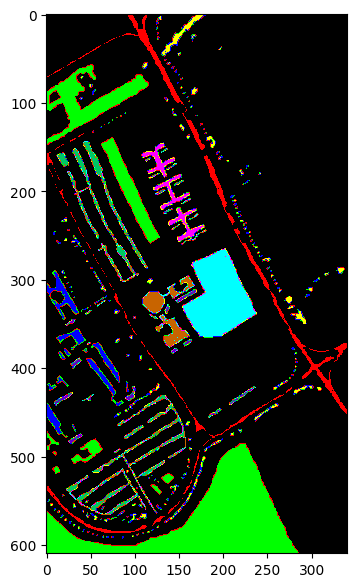

In [38]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

##### Predictions

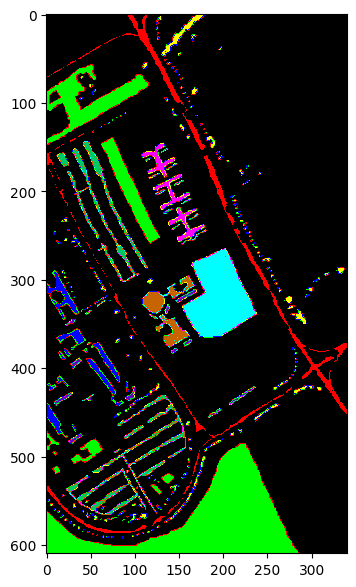

In [39]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))